In [6]:
push!(LOAD_PATH, ".")
using BenchmarkTools
using Plots
using IntervalSets
gr()

Plots.GRBackend()

In [7]:
struct knots
    vec :: Array{Float64,1}
    function knots(vec)
        new(sort(vec))
    end
end

Base.:+(k₁::knots, k₂::knots) = knots(sort([k₁.vec...,k₂.vec...]))
Base.:*(p₊::Int, k::knots) = if (p₊==0)
    knots([])
elseif (p₊>0)
    sum(k for _ ∈ 1:p₊)
else
    error("p₊ must be non-negative")
end
    
Base.getindex(k::knots, i::Int) = k.vec[i]
Base.getindex(k::knots, v::AbstractArray{Int64,1}) = knots(k.vec[v])
Base.length(k::knots) = length(k.vec)
Base.firstindex(k) = 1
Base.lastindex(k) = length(k)
Base.unique(k::knots) = knots(unique(k.vec))

function Base.:⊆(k::knots, k′::knots)
    K′=copy(k′.vec)
    for kᵢ ∈ k.vec
        i=findfirst(x->x==kᵢ,K′)
        if(i isa Nothing)
            return false
        end
        deleteat!(K′,i)
    end
    return true
end

function BSplineBasis(p::Int64,k::knots,t)::Array{Float64,1}
    n=length(k)-p-1
    if(p==0)
        return [k[i]≤t<k[i+1]||(k[i]≠k[i+1]==k[end]==t) for i ∈ 1:n]
    else
        K=[ifelse(k[i+p]==k[i],0,(t-k[i])/(k[i+p]-k[i])) for i ∈ 1:n+1]
        B=BSplineBasis(p-1,k,t)
        return [K[i]*B[i]+(1-K[i+1])*B[i+1] for i ∈ 1:n]
    end
end

function BSplineBasis(i::Int64,p::Int64,k::knots,t)::Float64
    return BSplineBasis(p,k[i:i+p+1],t)[1]
end

function BSplineBasis′(p::Int64,k::knots,t)::Array{Float64,1}
    n=length(k)-p-1
    if(p==0)
        return [0.0 for _ ∈ 1:n]
    else
        K=[ifelse(k[i+p]==k[i],0,p/(k[i+p]-k[i])) for i ∈ 1:n+1]
        B=BSplineBasis(p-1,k,t)
        return [K[i]*B[i]-K[i+1]*B[i+1] for i ∈ 1:n]
    end
end

function BSplineBasis′(i::Int64,p::Int64,k::knots,t)::Float64
    return BSplineBasis′(p,k[i:i+p+1],t)[1]
end

function BSplineSupport(i::Int64, p::Int64 ,k::knots)::ClosedInterval
    return k[i]..k[i+p+1]
end

function BSplineCoefficient(k::knots, p::Int, k′::knots, p′::Int)::Array{Float64,2}
    p₊=p′-p
    if(k+p₊*unique(k) ⊆ k′)
        if(p == 0 && p' ≥ 0)
            n=length(k)-1
            n′=length(k′)-p₊-1
            A⁰=Float64[BSplineSupport(j,p₊,k′) ⊆ BSplineSupport(i,0,k) for i ∈ 1:n, j ∈ 1:n′]
            return A⁰
        else
            Aᵖ⁻¹=BSplineCoefficient(k, p-1, k′, p′-1)
            n=length(k)-p-1
            n′=length(k′)-p′-1
            K′=[k′[i+p′]-k′[i] for i ∈ 1:n′+1]
            K=[1/(k[i+p]-k[i]) for i ∈ 1:n+1]
            LS=(p/p′)*[K′[j]*(K[i]*Aᵖ⁻¹[i,j]-K[i+1]*Aᵖ⁻¹[i+1,j]) for i ∈ 1:n, j ∈ 1:n′+1]
            Aᵖ₊, Aᵖ₋=zeros(n,n′), zeros(n,n′)
            Aᵖ₊[:,1]=LS[:,1]
            Aᵖ₋[:,n′]=-LS[:,n′+1]
            for j ∈ 2:n′
                Aᵖ₊[:,j]+=Aᵖ₊[:,j-1]+LS[:,j]
                Aᵖ₋[:,(n′-j+2)-1]+=Aᵖ₋[:,(n′-j+2)]-LS[:,(n′-j+2)]
            end
            return (Aᵖ₊+Aᵖ₋).*Float64[BSplineSupport(j,p′,k′) ⊆ BSplineSupport(i,p,k) for i ∈ 1:n, j ∈ 1:n′]/2
        end
    else
        error("P[p,k] ⊄ P[p′,k′]")
    end
end



BSplineCoefficient (generic function with 1 method)

In [9]:
p=4
p′=17
p₊=p′-p
k=knots((9*rand(20)).+3)
k₊=knots(((k[end]-k[1])*rand(13)).+k[1])
k′=k+p₊*unique(k)+k₊

knots([3.4641581656859843, 3.4641581656859843, 3.4641581656859843, 3.4641581656859843, 3.4641581656859843, 3.4641581656859843, 3.4641581656859843, 3.4641581656859843, 3.4641581656859843, 3.4641581656859843  …  11.549142053934085, 11.549142053934085, 11.549142053934085, 11.549142053934085, 11.549142053934085, 11.549142053934085, 11.549142053934085, 11.549142053934085, 11.549142053934085, 11.549142053934085])

In [18]:
@benchmark BSplineBasis(p,k,6.3)

BenchmarkTools.Trial: 
  memory estimate:  2.88 KiB
  allocs estimate:  36
  --------------
  minimum time:     2.025 μs (0.00% GC)
  median time:      2.141 μs (0.00% GC)
  mean time:        2.443 μs (7.08% GC)
  maximum time:     366.406 μs (98.66% GC)
  --------------
  samples:          10000
  evals/sample:     9

In [4]:
A=BSplineCoefficient(k,p, k′,p′)

15×275 Array{Float64,2}:
  1.3273e-6   6.63648e-6   1.99094e-5  …   0.0          0.0       
 -0.0        -0.0         -0.0             0.0          0.0       
  0.0         0.0          0.0            -0.0         -0.0       
  0.0         0.0          0.0            -0.0         -0.0       
  0.0         0.0          0.0            -0.0         -0.0       
  0.0         0.0          0.0         …  -0.0         -0.0       
 -0.0        -0.0         -0.0             0.0          0.0       
  0.0         0.0          0.0            -0.0         -0.0       
 -0.0        -0.0         -0.0             0.0          0.0       
 -0.0        -0.0         -0.0             0.0          0.0       
 -0.0        -0.0         -0.0         …   0.0          0.0       
  0.0         0.0          0.0            -0.0         -0.0       
 -0.0        -0.0         -0.0             0.0          0.0       
  0.0         0.0          0.0            -0.0         -0.0       
  0.0         0.0          0.0       

In [5]:
t=6
BSplineBasis(p,k,t)

15-element Array{Float64,1}:
 5.757812193918081e-6 
 0.20118578872851872  
 0.5644028620147034   
 0.23085933737782743  
 0.0035462540667566115
 0.0                  
 0.0                  
 0.0                  
 0.0                  
 0.0                  
 0.0                  
 0.0                  
 0.0                  
 0.0                  
 0.0                  

In [6]:
A*BSplineBasis(p′,k′,t)

15-element Array{Float64,1}:
 5.7578121939510535e-6
 0.20118578872851894  
 0.564402862014703    
 0.23085933737782752  
 0.0035462540667566644
 0.0                  
 0.0                  
 0.0                  
 0.0                  
 0.0                  
 0.0                  
 0.0                  
 0.0                  
 0.0                  
 0.0                  

In [50]:
@benchmark Bspline′(3,k,5)

BenchmarkTools.Trial: 
  memory estimate:  13.27 KiB
  allocs estimate:  28
  --------------
  minimum time:     3.494 μs (0.00% GC)
  median time:      3.832 μs (0.00% GC)
  mean time:        4.615 μs (9.37% GC)
  maximum time:     227.898 μs (97.08% GC)
  --------------
  samples:          10000
  evals/sample:     8

In [51]:
@benchmark [Ḃs(i,3,k,5) for i ∈ 1:length(k)-3-1]

BenchmarkTools.Trial: 
  memory estimate:  4.89 KiB
  allocs estimate:  199
  --------------
  minimum time:     20.679 μs (0.00% GC)
  median time:      21.881 μs (0.00% GC)
  mean time:        22.826 μs (0.73% GC)
  maximum time:     1.692 ms (98.51% GC)
  --------------
  samples:          10000
  evals/sample:     1

In [ ]:
Bspline′(3,k,5)-[Ḃs(i,3,k,5)

In [60]:
@benchmark [Bs(i,3,k,3.8) for i ∈ 1:length(k)-4]

BenchmarkTools.Trial: 
  memory estimate:  2.50 KiB
  allocs estimate:  3
  --------------
  minimum time:     24.546 μs (0.00% GC)
  median time:      24.967 μs (0.00% GC)
  mean time:        25.492 μs (0.00% GC)
  maximum time:     64.751 μs (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     1

In [61]:
@benchmark Bspline(3,k,3.8)

BenchmarkTools.Trial: 
  memory estimate:  18.27 KiB
  allocs estimate:  22
  --------------
  minimum time:     4.228 μs (0.00% GC)
  median time:      4.903 μs (0.00% GC)
  mean time:        6.247 μs (16.91% GC)
  maximum time:     449.644 μs (96.95% GC)
  --------------
  samples:          10000
  evals/sample:     7

In [68]:
@benchmark Bspline2(3,k,3.8)

BenchmarkTools.Trial: 
  memory estimate:  18.27 KiB
  allocs estimate:  22
  --------------
  minimum time:     4.914 μs (0.00% GC)
  median time:      5.524 μs (0.00% GC)
  mean time:        6.689 μs (15.28% GC)
  maximum time:     501.482 μs (96.57% GC)
  --------------
  samples:          10000
  evals/sample:     6

In [67]:
@benchmark Bspline3(3,k,3.8)

BenchmarkTools.Trial: 
  memory estimate:  18.33 KiB
  allocs estimate:  24
  --------------
  minimum time:     4.812 μs (0.00% GC)
  median time:      5.428 μs (0.00% GC)
  mean time:        6.585 μs (14.72% GC)
  maximum time:     456.199 μs (96.45% GC)
  --------------
  samples:          10000
  evals/sample:     6

In [33]:
24.731/5.733

4.3137973137973145

In [36]:
@benchmark Bspline2(3,k,4)

BenchmarkTools.Trial: 
  memory estimate:  18.27 KiB
  allocs estimate:  22
  --------------
  minimum time:     4.951 μs (0.00% GC)
  median time:      5.732 μs (0.00% GC)
  mean time:        6.754 μs (13.98% GC)
  maximum time:     415.472 μs (97.15% GC)
  --------------
  samples:          10000
  evals/sample:     6

In [41]:
replace(1,3)

replace (generic function with 9 methods)

In [40]:
?isnan

search: isnan isinvariant isinteractive issubnormal distinguishable_colors



```
isnan(f) -> Bool
```

Test whether a floating point number is not a number (NaN).


In [21]:
a=rand(3)
b=rand(4)
c=rand(5)

5-element Array{Float64,1}:
 0.88696523210706   
 0.8617377950737883 
 0.8030712506175677 
 0.8009584203347702 
 0.17219100978394208

In [ ]:
∧

In [54]:
function ⊗(X,Y)
    m=size(X)
    n=size(Y)
    reshape(reshape(X,length(X))*reshape(Y,length(Y))', m...,n...)
end

⊗ (generic function with 1 method)

In [55]:
[1,0] ⊗ [1,0,0,0] ⊗ [1,0,0]

2×4×3 Array{Int64,3}:
[:, :, 1] =
 1  0  0  0
 0  0  0  0

[:, :, 2] =
 0  0  0  0
 0  0  0  0

[:, :, 3] =
 0  0  0  0
 0  0  0  0

In [29]:
abc=reshape(reshape(a*b',3*4)*c',3,4,5);

In [31]:
abc[2,1,3]

0.4551482051732934

In [32]:
a[2]*b[1]*c[3]

0.4551482051732934

In [29]:
8.355/1.686

4.955516014234876

In [32]:
Bspline(3,k,4)

296-element Array{Float64,1}:
 0.0                 
 0.0                 
 0.0                 
 0.010679021664528285
 0.13088567669325832 
 0.5347286551039898  
 0.32370664653822356 
 0.0                 
 0.0                 
 0.0                 
 0.0                 
 0.0                 
 0.0                 
 ⋮                   
 0.0                 
 0.0                 
 0.0                 
 0.0                 
 0.0                 
 0.0                 
 0.0                 
 0.0                 
 0.0                 
 0.0                 
 0.0                 
 0.0                 

In [33]:
@benchmark Bspline(3,k,4)

BenchmarkTools.Trial: 
  memory estimate:  18.27 KiB
  allocs estimate:  22
  --------------
  minimum time:     4.174 μs (0.00% GC)
  median time:      5.007 μs (0.00% GC)
  mean time:        6.071 μs (15.34% GC)
  maximum time:     394.913 μs (97.96% GC)
  --------------
  samples:          10000
  evals/sample:     7

In [35]:
@benchmark Bspline2(3,k,4)

BenchmarkTools.Trial: 
  memory estimate:  18.27 KiB
  allocs estimate:  22
  --------------
  minimum time:     5.023 μs (0.00% GC)
  median time:      5.706 μs (0.00% GC)
  mean time:        6.790 μs (13.96% GC)
  maximum time:     521.471 μs (97.92% GC)
  --------------
  samples:          10000
  evals/sample:     6

In [149]:
@benchmark [Bs(i,3,k,6) for i ∈ 1:length(k)-4]

BenchmarkTools.Trial: 
  memory estimate:  512 bytes
  allocs estimate:  3
  --------------
  minimum time:     4.483 μs (0.00% GC)
  median time:      4.713 μs (0.00% GC)
  mean time:        4.983 μs (0.00% GC)
  maximum time:     30.169 μs (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     7

In [131]:
Bs(3,3,k,11)

0.0

In [127]:
@benchmark Bs(3,3,k,11)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     15.618 s (0.00% GC)
  median time:      15.618 s (0.00% GC)
  mean time:        15.618 s (0.00% GC)
  maximum time:     15.618 s (0.00% GC)
  --------------
  samples:          1
  evals/sample:     1

In [128]:
@benchmark Bspline(3,30,k,11)

BenchmarkTools.Trial: 
  memory estimate:  17.41 KiB
  allocs estimate:  187
  --------------
  minimum time:     4.411 μs (0.00% GC)
  median time:      4.971 μs (0.00% GC)
  mean time:        6.515 μs (18.95% GC)
  maximum time:     601.284 μs (98.18% GC)
  --------------
  samples:          10000
  evals/sample:     7

In [130]:
Bspline(3,30,k,11)

0.21767468873898255

In [76]:
[Bs(i,3,k₂,5) for i ∈ 1:length(k₂)-4]

46-element Array{Float64,1}:
 0.0                 
 0.2672670770378333  
 0.5360725708325609  
 0.1897151173333329  
 0.006945234796272792
 0.0                 
 0.0                 
 0.0                 
 0.0                 
 0.0                 
 0.0                 
 0.0                 
 0.0                 
 ⋮                   
 0.0                 
 0.0                 
 0.0                 
 0.0                 
 0.0                 
 0.0                 
 0.0                 
 0.0                 
 0.0                 
 0.0                 
 0.0                 
 0.0                 

In [8]:
using BenchmarkTools

In [9]:
@benchmark Bs(10,3,k₁,10)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     93.504 ns (0.00% GC)
  median time:      95.189 ns (0.00% GC)
  mean time:        100.478 ns (0.00% GC)
  maximum time:     220.149 ns (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     952

In [10]:
@benchmark Bs(10,5,k₂,10)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     438.141 ns (0.00% GC)
  median time:      459.293 ns (0.00% GC)
  mean time:        476.640 ns (0.00% GC)
  maximum time:     1.335 μs (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     198

In [11]:
@benchmark Bs(10,7,k₂,10)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     1.820 μs (0.00% GC)
  median time:      1.849 μs (0.00% GC)
  mean time:        1.889 μs (0.00% GC)
  maximum time:     9.743 μs (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     10

In [12]:
@benchmark Bs(10,30,k₂,10)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     13.791 s (0.00% GC)
  median time:      13.791 s (0.00% GC)
  mean time:        13.791 s (0.00% GC)
  maximum time:     13.791 s (0.00% GC)
  --------------
  samples:          1
  evals/sample:     1

In [630]:
norm(Bcoeff(k,p,k′,p′)-Bcoeff2(k,p,k′,p′))

1.6589766381685647e-6

In [631]:
norm(Bcoeff(k,p,k′,p′)-Bcoeff3(k,p,k′,p′))

1.6589766381685647e-6

BsCoef (generic function with 1 method)

In [622]:
vcat([BsCoef(t->Bs(i,p,k,t),p′,k′) for i ∈ 1:length(k)-p-1]'...)

16×36 Array{Float64,2}:
  0.0317713     0.251025      0.594924     …  0.0       0.0  0.0     
  2.19006e-16  -6.93575e-14   2.70936e-12     0.0       0.0  0.0     
  1.42314e-17   1.52304e-15  -6.04162e-14     0.0       0.0  0.0     
 -1.21495e-19  -4.10709e-17   1.61653e-15     0.0       0.0  0.0     
  1.27868e-26  -2.0945e-24    8.15201e-23     0.0       0.0  0.0     
 -1.47897e-27   2.42258e-25  -9.42893e-24  …  0.0       0.0  0.0     
 -2.58515e-27   4.23451e-25  -1.64812e-23     0.0       0.0  0.0     
  0.0           0.0           0.0             0.0       0.0  0.0     
  0.0           0.0           0.0             0.0       0.0  0.0     
  0.0           0.0           0.0             0.0       0.0  0.0     
 -1.14804e-42   1.8805e-40   -7.31912e-39  …  0.0       0.0  0.0     
  2.8701e-43   -4.70125e-41   1.82978e-39     0.0       0.0  0.0     
  0.0           0.0           0.0             0.0       0.0  0.0     
  2.93898e-40  -4.81408e-38   1.87369e-36     0.0       0.0  0.0  

In [623]:
Bcoeff2(k,p,k′,p′)

16×36 Transpose{Float64,Array{Float64,2}}:
  0.0317713     0.251025      0.594924     …  0.0       0.0  0.0     
  2.19006e-16  -6.93575e-14   2.70936e-12     0.0       0.0  0.0     
  1.42314e-17   1.52304e-15  -6.04162e-14     0.0       0.0  0.0     
 -1.21495e-19  -4.10709e-17   1.61653e-15     0.0       0.0  0.0     
  1.27868e-26  -2.0945e-24    8.15201e-23     0.0       0.0  0.0     
 -1.47897e-27   2.42258e-25  -9.42893e-24  …  0.0       0.0  0.0     
 -2.58515e-27   4.23451e-25  -1.64812e-23     0.0       0.0  0.0     
  0.0           0.0           0.0             0.0       0.0  0.0     
  0.0           0.0           0.0             0.0       0.0  0.0     
  0.0           0.0           0.0             0.0       0.0  0.0     
 -1.14804e-42   1.8805e-40   -7.31912e-39  …  0.0       0.0  0.0     
  2.8701e-43   -4.70125e-41   1.82978e-39     0.0       0.0  0.0     
  0.0           0.0           0.0             0.0       0.0  0.0     
  2.93898e-40  -4.81408e-38   1.87369e-36     0

In [684]:
3knot([1,2])

knot([1.0, 1.0, 1.0, 2.0, 2.0, 2.0])

* (generic function with 407 methods)

issubset (generic function with 10 methods)

In [711]:
knot([2,3,3,5]) ⊆ knot([1,2,3,5])

false

In [712]:
knot([2,3,5]) ⊆ knot([1,2,3,5])

true

In [ ]:
findall(x->x==2, A)

In [ ]:
BSp

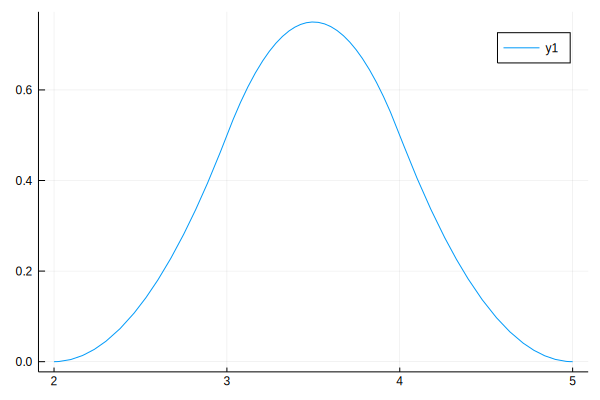

In [424]:
p=2
f=[t->BSplineBasis(i,p,k,t) for i ∈ 1:length(k)-p-1]
plot(f, k[1], k[end])

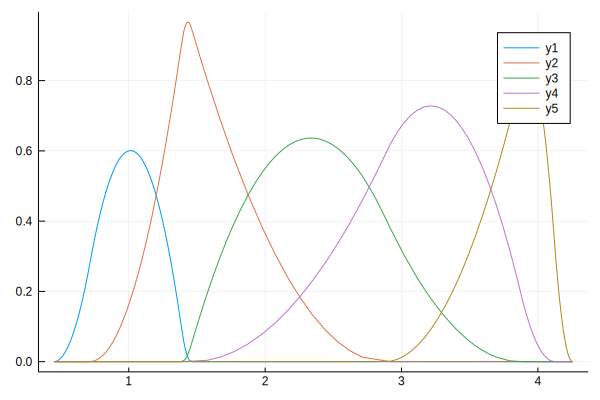

In [235]:
n=length(k̄)-p-1
f=[t->0+
    Aᵖᵢⱼ[i,1]*(t-k̄[1])/(k̄[1+p]-k̄[1])*Bs(1,p-1,k̄,t)+
    sum((
            (Aᵖᵢⱼ[i,j]*(t-k̄[j])/(k̄[j+p]-k̄[j])+Aᵖᵢⱼ[i,j-1]*(k̄[j-1+p+1]-t)/(k̄[j-1+p+1]-k̄[j]))*Bs(j,p-1,k̄,t)
            ) for j ∈ 2:n)+
    Aᵖᵢⱼ[i,n]*(k̄[n+p+1]-t)/(k̄[n+p+1]-k̄[n+1])*Bs(n+1,p-1,k̄,t)
    for i ∈ 1:length(k)-p-1]
plot(f, k[1], k[end])